In [1]:
%matplotlib inline

import pandas as pd
import geopandas
import json
from shapely.geometry import Point


In [2]:
zones = geopandas.read_file('ref_data/idf_departements.geojson', driver='GeoJSON')
zones.head()
#zones.plot()

,id,osm_id,parent,zone_type,name,center,admin_leve,wikidata,geometry
0,0,7383,8,state_district,Seine-et-Marne,"{'y': 48.539927, 'x': 2.660817}",6,Q12753,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28..."
1,1,7389,8,state_district,Seine-Saint-Denis,"{'y': 48.906387, 'x': 2.445223}",6,Q12761,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0..."
2,2,7401,8,state_district,Essonne,"{'y': 48.6311, 'x': 2.438}",6,Q3368,"POLYGON ((2.233067 48.766197, 2.233127 48.7662..."
3,3,7433,8,state_district,Val-d'Oise,"{'y': 49.052753, 'x': 2.038874}",6,Q12784,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9..."
4,5,7449,8,state_district,Hauts-de-Seine,"{'y': 48.892427, 'x': 2.207127}",6,Q12543,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95..."


In [3]:
osm_routepoints = pd.read_csv("../data/osm_routepoints.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints = pd.read_csv("../data/gtfs_routepoints.csv", dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
gtfs_routepoints.head()

,gtfs_stop_id,gtfs_route_id,gtfs_ZDEr_ID_REF_A,gtfs_stop_name,gtfs_stop_lat,gtfs_stop_lon,gtfs_wheelchair_boarding,gtfs_dest_name,gtfs_route_short_name,gtfs_agency_name
0,StopPoint:4:110,002002002:BDE,10296,Général de Gaulle,48.73564,2.424307,NaN,Hotels,BDE,Keolis Seine Val-De-Marne
1,StopPoint:4:111,002002002:BDE,423888,Général de Gaulle,48.735631,2.42413,NaN,Hotels,BDE,Keolis Seine Val-De-Marne
2,StopPoint:4:112,002002002:BDE,2708,Ecoles,48.73257,2.442115,NaN,Hotels,BDE,Keolis Seine Val-De-Marne
3,StopPoint:4:113,002002002:BDE,21636,Ecoles,48.732705,2.441857,NaN,Hotels,BDE,Keolis Seine Val-De-Marne
4,StopPoint:4:114,002002002:BDE,21637,EDF,48.729472,2.438712,NaN,Hotels,BDE,Keolis Seine Val-De-Marne


In [4]:
def lat_lon_to_geom(row):
    return Point(float(row['gtfs_stop_lon']),float(row['gtfs_stop_lat']))

gtfs_routepoints['geometry'] = gtfs_routepoints.apply(lat_lon_to_geom, axis=1)

crs = {'init': 'epsg:4326'}
gdf = geopandas.GeoDataFrame(gtfs_routepoints, crs=crs, geometry=gtfs_routepoints.geometry)


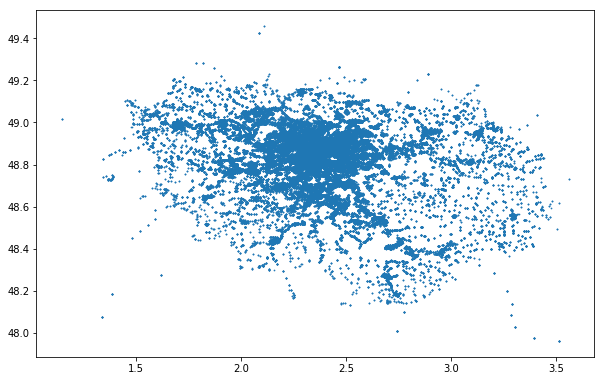

In [17]:
gdf.plot(markersize=0.5, figsize=(10, 10))

In [6]:
stations = geopandas.sjoin(gdf, zones[['name', 'geometry']].copy(), op='within')
counts = stations.groupby('name').size()
densite_dptm = zones.merge(counts.reset_index(name='densite')) #TODO renommer en nb_stops

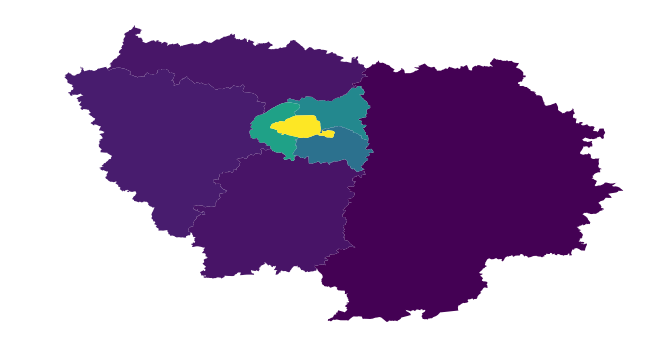

In [7]:
densite_dptm['densite_normalise'] = densite_dptm['densite'] / densite_dptm.geometry.area
ax = densite_dptm.plot(column='densite_normalise', figsize=(15, 6))
ax.set_axis_off()


In [8]:
densite_dptm

,id,osm_id,parent,zone_type,name,center,admin_leve,wikidata,geometry,densite,densite_normalise
0,0,7383,8,state_district,Seine-et-Marne,"{'y': 48.539927, 'x': 2.660817}",6,Q12753,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",26004,35962.450641
1,1,7389,8,state_district,Seine-Saint-Denis,"{'y': 48.906387, 'x': 2.445223}",6,Q12761,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",8939,307469.791796
2,2,7401,8,state_district,Essonne,"{'y': 48.6311, 'x': 2.438}",6,Q3368,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",14701,66361.563898
3,3,7433,8,state_district,Val-d'Oise,"{'y': 49.052753, 'x': 2.038874}",6,Q12784,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",10638,68970.185639
4,5,7449,8,state_district,Hauts-de-Seine,"{'y': 48.892427, 'x': 2.207127}",6,Q12543,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",7965,370143.551495
5,6,7457,8,state_district,Yvelines,"{'y': 48.80354, 'x': 2.126689}",6,Q12820,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",22397,79289.241419
6,7,7458,8,state_district,Val-de-Marne,"{'y': 48.783073, 'x': 2.451837}",6,Q12788,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",7599,253606.487256
7,126,71525,8,state_district,Paris,"{'y': 48.85661, 'x': 2.351499}",6,Q90,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",7992,618903.204016


In [9]:
import folium
m = folium.Map([48.8566, 2.3429], zoom_start=12, tiles="OpenStreetMap")
m.choropleth(geo_data=densite_dptm, data=densite_dptm, columns=['name', 'densite_normalise'],
             key_on='feature.properties.name', fill_color='YlOrRd', highlight=True)


m

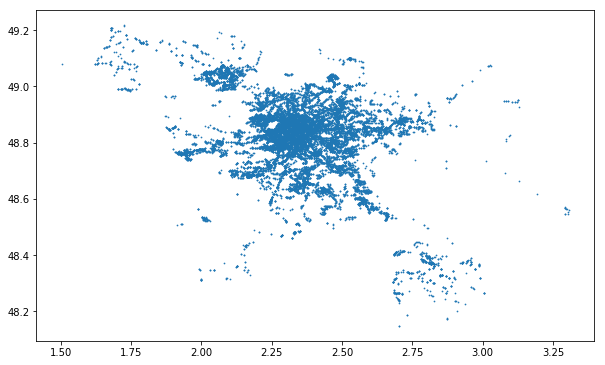

In [19]:
def lat_lon_to_geom(row):
    return Point(float(row['osm_lon']),float(row['osm_lat']))

osm_routepoints['geometry'] = osm_routepoints.apply(lat_lon_to_geom, axis=1)

crs = {'init': 'epsg:4326'}
osm_geo = geopandas.GeoDataFrame(osm_routepoints, crs=crs, geometry=osm_routepoints.geometry)
osm_geo.plot(markersize=0.5, figsize=(10, 10))
#TODO : il y a des clusters amusants, regarder plus en détail où ils sont

In [11]:
osm_routepoints_with_zones = geopandas.sjoin(osm_geo, zones[['name', 'geometry']].copy(), op='within')
counts_osm = osm_routepoints_with_zones.groupby('name').size()
densite_dptm_with_osm = zones.merge(counts_osm.reset_index(name='nb_stop_osm'))
densite_dptm_with_osm

,id,osm_id,parent,zone_type,name,center,admin_leve,wikidata,geometry,nb_stop_osm
0,0,7383,8,state_district,Seine-et-Marne,"{'y': 48.539927, 'x': 2.660817}",6,Q12753,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",2770
1,1,7389,8,state_district,Seine-Saint-Denis,"{'y': 48.906387, 'x': 2.445223}",6,Q12761,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",2162
2,2,7401,8,state_district,Essonne,"{'y': 48.6311, 'x': 2.438}",6,Q3368,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",3434
3,3,7433,8,state_district,Val-d'Oise,"{'y': 49.052753, 'x': 2.038874}",6,Q12784,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",2962
4,5,7449,8,state_district,Hauts-de-Seine,"{'y': 48.892427, 'x': 2.207127}",6,Q12543,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",3413
5,6,7457,8,state_district,Yvelines,"{'y': 48.80354, 'x': 2.126689}",6,Q12820,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",1541
6,7,7458,8,state_district,Val-de-Marne,"{'y': 48.783073, 'x': 2.451837}",6,Q12788,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",3341
7,126,71525,8,state_district,Paris,"{'y': 48.85661, 'x': 2.351499}",6,Q90,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",4400


In [12]:
densite_dptm_total = densite_dptm_with_osm.merge(densite_dptm[['densite', 'name']].copy(),on='name')
densite_dptm_total

,id,osm_id,parent,zone_type,name,center,admin_leve,wikidata,geometry,nb_stop_osm,densite
0,0,7383,8,state_district,Seine-et-Marne,"{'y': 48.539927, 'x': 2.660817}",6,Q12753,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",2770,26004
1,1,7389,8,state_district,Seine-Saint-Denis,"{'y': 48.906387, 'x': 2.445223}",6,Q12761,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",2162,8939
2,2,7401,8,state_district,Essonne,"{'y': 48.6311, 'x': 2.438}",6,Q3368,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",3434,14701
3,3,7433,8,state_district,Val-d'Oise,"{'y': 49.052753, 'x': 2.038874}",6,Q12784,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",2962,10638
4,5,7449,8,state_district,Hauts-de-Seine,"{'y': 48.892427, 'x': 2.207127}",6,Q12543,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",3413,7965
5,6,7457,8,state_district,Yvelines,"{'y': 48.80354, 'x': 2.126689}",6,Q12820,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",1541,22397
6,7,7458,8,state_district,Val-de-Marne,"{'y': 48.783073, 'x': 2.451837}",6,Q12788,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",3341,7599
7,126,71525,8,state_district,Paris,"{'y': 48.85661, 'x': 2.351499}",6,Q90,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",4400,7992


In [13]:
densite_dptm_total["couverture_osm"] = densite_dptm_total["nb_stop_osm"] * 100.0 / densite_dptm_total["densite"]
densite_dptm_total
#TODO : à comparer avec les chiffres bruts du nombre d'arrêts pour vérifier si c'est cohérent

,id,osm_id,parent,zone_type,name,center,admin_leve,wikidata,geometry,nb_stop_osm,densite,couverture_osm
0,0,7383,8,state_district,Seine-et-Marne,"{'y': 48.539927, 'x': 2.660817}",6,Q12753,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",2770,26004,10.652207
1,1,7389,8,state_district,Seine-Saint-Denis,"{'y': 48.906387, 'x': 2.445223}",6,Q12761,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",2162,8939,24.186151
2,2,7401,8,state_district,Essonne,"{'y': 48.6311, 'x': 2.438}",6,Q3368,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",3434,14701,23.358955
3,3,7433,8,state_district,Val-d'Oise,"{'y': 49.052753, 'x': 2.038874}",6,Q12784,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",2962,10638,27.843580
4,5,7449,8,state_district,Hauts-de-Seine,"{'y': 48.892427, 'x': 2.207127}",6,Q12543,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",3413,7965,42.849969
5,6,7457,8,state_district,Yvelines,"{'y': 48.80354, 'x': 2.126689}",6,Q12820,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",1541,22397,6.880386
6,7,7458,8,state_district,Val-de-Marne,"{'y': 48.783073, 'x': 2.451837}",6,Q12788,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",3341,7599,43.966311
7,126,71525,8,state_district,Paris,"{'y': 48.85661, 'x': 2.351499}",6,Q90,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",4400,7992,55.055055


In [14]:
m = folium.Map([48.8566, 2.3429], zoom_start=12, tiles="OpenStreetMap")
m.choropleth(geo_data=densite_dptm_total, data=densite_dptm_total, columns=['name', 'couverture_osm'],
             key_on='feature.properties.name', fill_color='YlOrRd', highlight=True)


m

In [26]:
len(list(set(osm_routepoints['osm_network'])))
len(list(set(gtfs_routepoints['gtfs_agency_name'])))
#tenter un groupby par agency et un merge pour avoir des stats par réseau ? ça risque de pas matcher souvent ...

119

In [48]:
osm_networks = pd.DataFrame(osm_routepoints.groupby('osm_network').size()).reset_index()
gtfs_networks = pd.DataFrame(gtfs_routepoints.groupby('gtfs_agency_name').size()).reset_index()
networks = gtfs_networks.merge(osm_networks, how='outer', right_on=['osm_network'], left_on=['gtfs_agency_name'])
networks.rename(columns={'0_x': 'gtfs_count', '0_y': 'osm_count'}, inplace=True)
networks


,gtfs_agency_name,gtfs_count,osm_network,osm_count
0,ADP,15.0,NaN,NaN
1,AUTOCARS DOMINIQUE,32.0,NaN,NaN
2,Actipôles,306.0,NaN,NaN
3,Albatrans,437.0,NaN,NaN
4,Apolo 7,909.0,Apolo 7,132.0
5,Arlequin,487.0,Arlequin,50.0
6,Aubergenville,57.0,NaN,NaN
7,Autobus du Fort,44.0,Autobus du Fort,11.0
8,Autocars Tourneux,1126.0,NaN,NaN
9,Aérial,638.0,Aérial,40.0
